## Clustering

Up to this point, we have focused on supervised learning - meaning that we have labels for our data that we use to train a model. Another type of machine learning is **unsupervised**. These algorithms work without having labeled data. Obviously, this is a great feature since it eliminates the need to gather labels, but it also comes at the cost of usually being less powerful and needed more manual inspection.

## K-Means Clustering

Probably the most famous clustering algorithm is k-means. We will start here to illustrate the task of clustering and see an example of how to solve it. 

The goal of clustering is to discover groups of data within our data where observations within a group are similar to eachother and different from other groups. An example might be market segmentation. Imagine having a bunch of data on customers for your business and you want to discover groups of similar customers. One such group might be high spenders and another group maybe window shoppers. 

K-means clustering solves this problem by finding **K (hyper-paramter) distinct** clusters in a set of data by using the features of the given data. Let's take a look at an example of some simple data:

In [26]:
from sklearn.datasets import load_breast_cancer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd

In [2]:
df = pd.read_csv("../small_data/Wholesale customers data.csv")
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


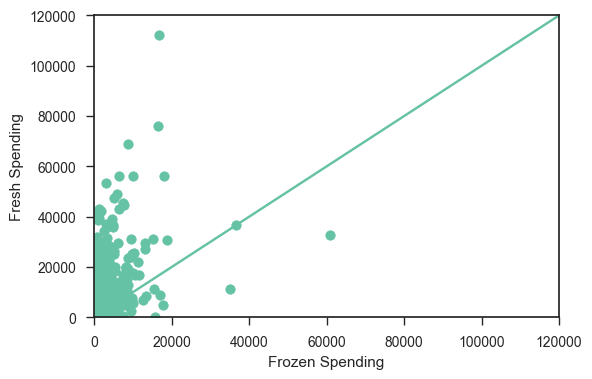

In [28]:
plt.scatter(df['Frozen'], df['Fresh'])
plt.xlabel("Frozen Spending")
plt.ylabel("Fresh Spending")
plt.xlim(0,120000)
plt.ylim(0,120000)
plt.plot(range(120000), range(120000))

Above, we have annual spending for differnt channel/regions on various grocery categories. I have picked fresh and frozen to visualize. We can see that there are regions that prefer to spend more on frozen over fresh and some that much prefer fresh to frozen and a lot that around around equal. How might we cluster these points?

K-means solves this problem by trying to minimize the variation within a cluster, specifically we want to minimize the squared distance between all the pairwise points within a cluster. Thus, k-means takes the average squared distance between the points in each cluster and then adds up all of those averages to get the total variation in our clustering. This is the value we want to minimze. The algorithm goes like this:

It turns out that solving this minimization exactly is very hard, so we use an algorithm that finds a **local optimum**. The algorithm goes like this:

1. Randomly assign a cluster to every data point (1 - K)
2. Repeat until converge (cluster assignments stop changing):

    a. For every cluster, compute the centroid - the mean value for every feature for the points in that cluster
    
    b. Assign every point to closest cluster by euclidian distance (squared distance)
    
This algorithm gaurantees to continue to decrease the total cluster variation until it no longer changes - the local minimum. The fact that it is local also means that the result depends on the original, random inital cluster assignments. Thus, it is valuable to run the algorithm multiple times and choosing the one that best minimizes the total variation.

## Raw Python for K-Means Clustering

K-means is a pretty easy algorithm to write from scratch; especially when using some helper functions provided by pandas and sklearn:

In [29]:
from sklearn.metrics.pairwise import euclidean_distances

def k_means(k, data):
    copy_data = data.copy()
    rows, features = copy_data.shape
    copy_data['cluster_assignments'] = np.random.randint(0, k, rows)
    did_change = 1
    while did_change:
        centroids = copy_data.groupby('cluster_assignments').mean()
        new_assignments = np.argmin(euclidean_distances(data.values[:,:features], centroids.values), 1)
        if np.array_equal(copy_data['cluster_assignments'].values, np.array(new_assignments)):
            did_change = 0
        else:
            copy_data['cluster_assignments'] = new_assignments
    return copy_data['cluster_assignments'].values

In [30]:
clusters = k_means(3, df[['Frozen', 'Fresh']])

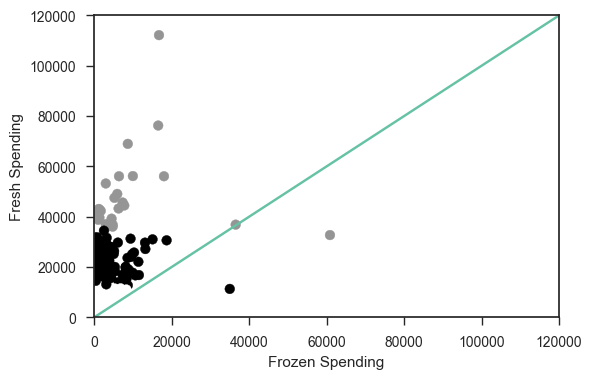

In [35]:
plt.scatter(df['Frozen'], df['Fresh'], c=clusters)
plt.xlabel("Frozen Spending")
plt.ylabel("Fresh Spending")
plt.xlim(0,120000)
plt.ylim(0,120000)
plt.plot(range(120000), range(120000))

There you have it! K-means from scratch-ish. We have visualized the five selected clusters and things seem to be working right.

Here is how you would do it using sklearn:

## SKLearn Example

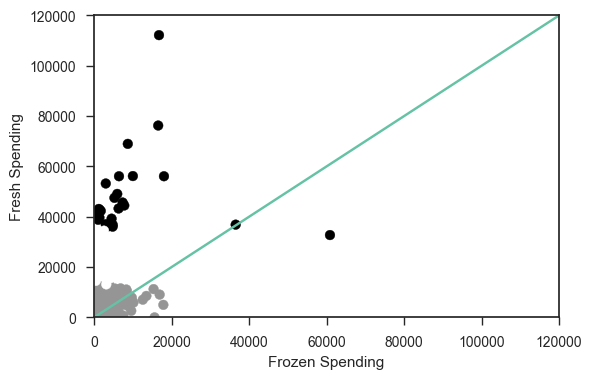

In [42]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, n_init=50, n_jobs=-1)
kmeans.fit(df[['Frozen', 'Fresh']])
sk_clusters = kmeans.predict(df[['Frozen', 'Fresh']])

plt.scatter(df['Frozen'], df['Fresh'], c=sk_clusters)
plt.xlabel("Frozen Spending")
plt.ylabel("Fresh Spending")
plt.xlim(0,120000)
plt.ylim(0,120000)
plt.plot(range(120000), range(120000))

Looks pretty similar! Nice!

## Practical Tips

* How to choose K?

So - you are probably wondering how you might choose k? Especially, when the data are in higher dimensions than 2. Well, sometimes the problem might dictate a reasonable value of k. For example, if the marketing team knows they want 5 segments of customers. Or you just might have strong prior knowledge that help guide your choice. 

Otherwise, a common method is the **elbow method**. This method says try a bunch of k values and plot their resulting sum squared distances and choose k at the elbow in the graph. Let's look at an example:

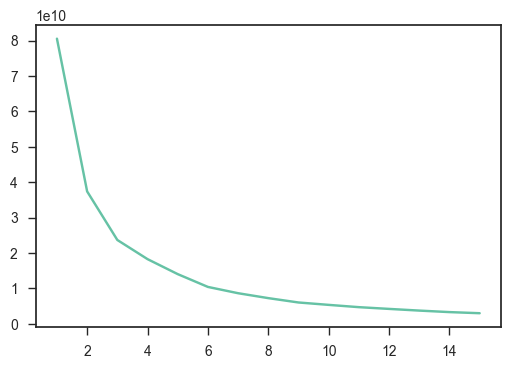

In [45]:
sses = []
for k in range(1,16):
    kmeans = KMeans(n_clusters=k, n_init=50, n_jobs=-1)
    kmeans.fit(df[['Frozen', 'Fresh']])
    sses.append(kmeans.inertia_)
plt.plot(range(1,16), sses)

Here it looks like maybe the elbow in the graph is around 6 clusters for our data, so with this method that would be the value of k we would choose. Obviously, this is heuristic and far from scientific. It is also important to note that the sum of the squared distances will always decrease as k increases.

* Should you scale data?

As we have learned, scaling features can be important. This also applies to k-means clustering because we are taking distances between points. If your data have defined distances like lat and long data, then you should not scale as you will distort the distances between points. If, on the other hand, you are clustering on features that are not really comparable, scaling could be a good choice. In practice, it is best to try both and look at the results to see what patterns emerge.

* How to evaluate?

Evaluating clustering assignments is more challenging than with supervised learning. Sklearn has some nice documentation on popular methods, though:

http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

Many of these assume knowledge of the ground truth, which make them less valuable. When no ground truth is known a metric like the Silhouette Coefficient can be useful.  This coefficient is the mean distance between a sample and all other points in the next nearest cluste subtracted by the mean distance between a sample and all other points in the same class.  The score is better when higher and ranges from -1 to 1. A higher score means the clusters are dense and well seperated. Here is an example:

In [9]:
from sklearn.metrics import silhouette_score

kmeans_model = KMeans(n_clusters=5, n_init=50, n_jobs=-1).fit(df[['Frozen', 'Fresh']])
labels = kmeans_model.labels_
silhouette_score(df[['Frozen', 'Fresh']], labels, metric='euclidean')

0.5060667148131143

* Clustering can be non-robust

Small changes in data can lead to large changes in clustering, so useful to perform the clustering on many subsets of data to test robustness.

In general, clustering results should not be taken as truth and many different values of the parameters discussed should be tried and analyzed. Usually this then is a good start further study to help validate findings.

## Hierarchical Clustering

This is another type of clustering that doesn't require us to provide a value for k. We will be describing bottom-up or agglomerative clustering.

To understand agglomerative clustering it can be useful to start with a picture. Let's start with our simple iris data example. Here is a scatter plot of two of the variables just for visualization, but for the clustering we will use all 4.

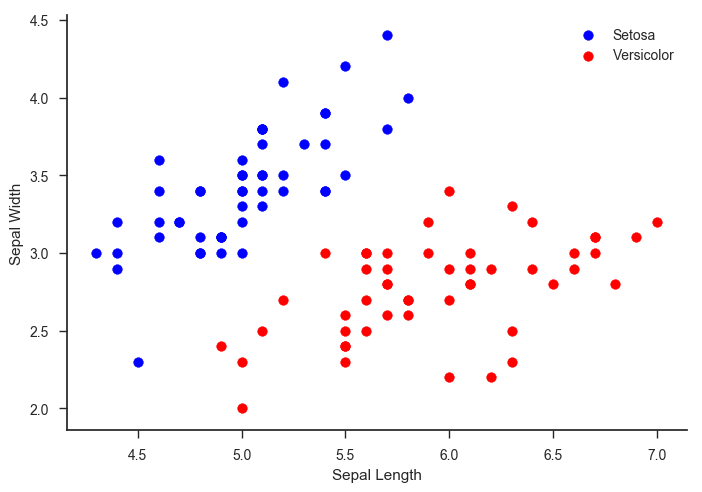

In [10]:
from sklearn import datasets
import seaborn as sns
sns.set(style='ticks', palette='Set2')

data = datasets.load_iris()
X = data.data[:100, :2]
y = data.target[:100]
X_full = data.data[:100, :]

setosa = plt.scatter(X[:50,0], X[:50,1], c='b')
versicolor = plt.scatter(X[50:,0], X[50:,1], c='r')
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.legend((setosa, versicolor), ("Setosa", "Versicolor"))
sns.despine()

And here is the output of our agglomerative clustering. We used scipy's linkage function to calculate the relationships between all the points and then plotted the visualization which is called a **dendrogram**.

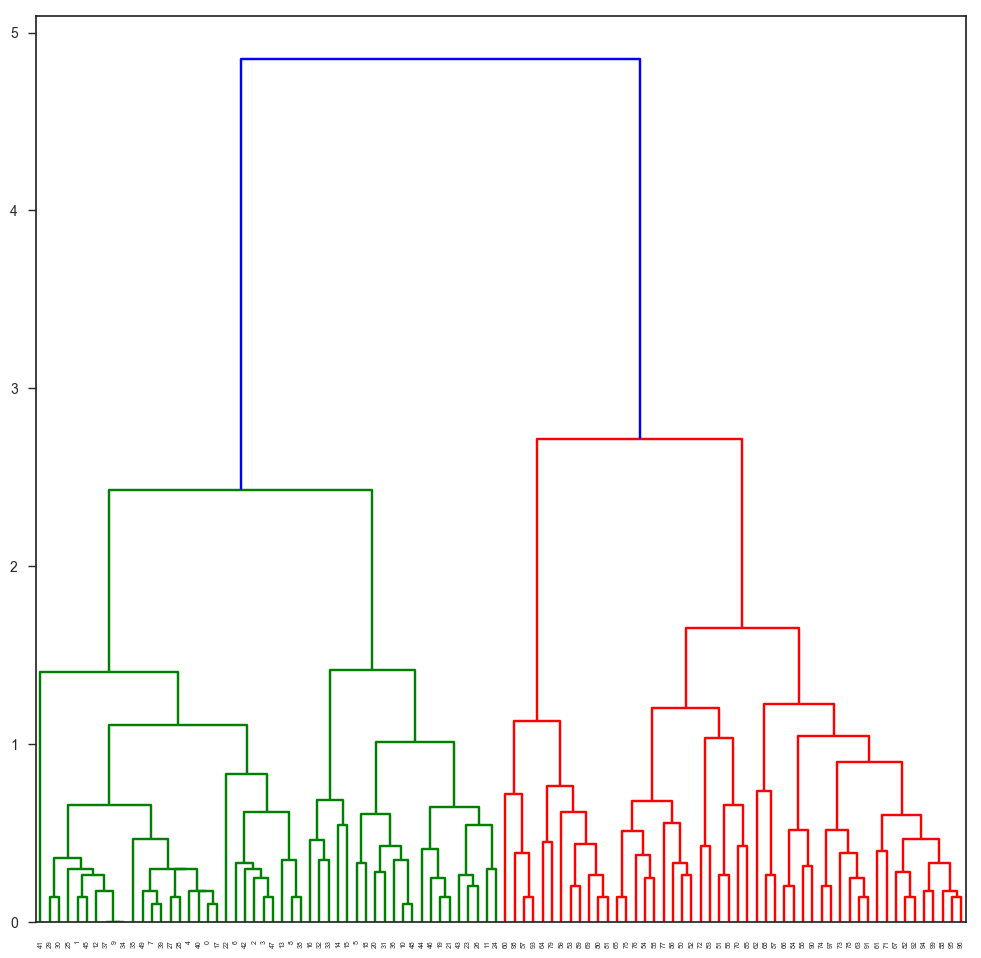

In [11]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(X_full, 'complete')
plt.figure(figsize=(12, 12))
_ = dendrogram(Z)

What this dendrogram is showing is how we took all the points and aggregate them up into one cluster. You start with every point being its own cluster and then combine them to the next closest cluster and keep repeating untill every point is in a single cluster - the top of the denrogram.

Thus, the earlier thing combine, the more similar they are. And you can see that are clustering did in fact find two major clusters, which is good since we have two classes in this example. But each of those major clusters is made up of smaller combinations until you get down to the individual data points.

One nice component of this graph is if we want to know how similar two points are, we just need to see at what height they are fused together. It is also important to note that closeness along the x-axis has no bearing on similarity between points. Though, most packages try to group closer points together on the x-axis.

So, how do we choose the number of clusters we want from agglomerative clustering? Simple - you draw a horizontal line at they y-axis value you think is reasonable and the number of vertical lines it crosses is the number of clusters you get - where the distinct sets beneath the line are your clusters. For example, drawing a line at y=4, would give us 2 clusters. This seems to make sense given our graph and usually one selects the value by analyzing the dendrogram and the heights of various fusions and taking into account any knowledge of the problem. Often, the selection is not as clear as shown above.

Heirachical clustering can perform poorly relative to k-means clustering when this heirarchical assumption is not valid - for example, when clusters are not nested such that splitting large clusters into smaller ones is not accurate.

## The Algorithm

The algorithm goes something like this:

1. Start with every point as its own cluster - thus n clusters if have n points
2. Define a distance metric between clusters - usually euclidian distance
3. The two most similar clusters are merged - resulting in n-1 clusters
4. Given these now n-1 clusters, the next two closest are merged, resulting in n-2 clusters
5. Repeat until have 1 cluster

The only question remaining for us to answer is **how to measure distance between clusters made up of more than one point?** There are a few options:

1. Complete - Use the maximum distance between points in clusters
2. Ward - Merge the two clusters which minimize the total within-cluster variance after merging
3. Average - Use the average distance between points in clusters
4. Single (no sklearn) - Use the minimum distance between points in clusters
5. Centroid (no sklearn) - Use the distance between the mean vector of each cluster

The above methods are called linkage methods. Obviously, the choice of linkage and distance metrics can have a large impact on the results. The default linkage method for sklearn is ward. Average and complete linkage are generally preferred over single linkage and centroid linkage can lead to inversions where two clusters are fused at a height below either of the individual clusters in the dendrogram. 

To decide on which metrics to use and whether to scale the data, think carefully about the type of data you are using and the question you are trying to answer. See p.396 of ISLR. 

## Other Clustering Algorithms

There are many other clustering algorithms, but some of the best ones are explained pretty well in this article:

https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68

I would emphasis looking at dbscan as well as gmm.